In [17]:
from src.data_loader import load_fd001
from src.features import add_features, add_rul

# Load dataset (correct filename!)
df = load_fd001("data/train_FD001.txt")

# Add RUL + engineered features (using the NEW features.py)
df_rul = add_rul(df)
df_feat = add_features(df_rul)

# Preview
df_feat.head()


,engine_id,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_19,sensor_20,sensor_21,RUL,sensor_7_roll,sensor_7_diff,sensor_11_roll,sensor_11_diff,sensor_12_roll,sensor_12_diff
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,100.0,39.06,23.4190,191,554.360000,0.00,47.470000,0.00,521.66,0.00
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,100.0,39.00,23.4236,190,554.055000,-0.61,47.480000,0.02,521.97,0.62
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,100.0,38.95,23.3442,189,554.123333,0.51,47.410000,-0.22,522.12,0.14
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,100.0,38.88,23.3739,188,554.153333,0.19,47.296667,-0.14,522.52,0.44
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,100.0,38.90,23.4044,187,554.236667,-0.45,47.226667,0.15,522.49,-0.67


In [18]:
from src.model_utils import train_random_forest, save_model

# Split features/labels
X = df_feat.drop(columns=['engine_id', 'cycle', 'RUL'])
y = df_feat['RUL']
groups = df_feat['engine_id']

# Train a new Random Forest
model = train_random_forest(X, y, groups, n_estimators=100, max_depth=10)

# Save model WITH feature names baked in
save_model(model, "rf_model_test.pkl", feature_names=X.columns.tolist())


Fold 1: MAE=31.55, RMSE=45.73
Fold 2: MAE=30.21, RMSE=42.91
Fold 3: MAE=26.95, RMSE=39.39
Fold 4: MAE=32.95, RMSE=44.73
Fold 5: MAE=26.31, RMSE=37.62

Avg MAE=29.60, Avg RMSE=42.08


TypeError: save_model() got an unexpected keyword argument 'feature_names'

In [1]:
import os

# Make sure we're always running from the project root
os.chdir(r"C:\Users\matga\OneDrive\BillionDollarJetSoftware")


In [ ]:
# ============================================================
# engine_predictor.ipynb - Billion Dollar Jet Software
# ============================================================

import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib
import xgboost as xgb

# Load dataset (works with FD001.txt or train_FD001.txt)
col_names = ["engine_id", "cycle"] + \
            [f"setting_{i}" for i in range(1,4)] + \
            [f"sensor_{i}" for i in range(1,22)]

DATA_DIR = "data"
data_path = None
for fname in ["train_FD001.txt", "FD001.txt"]:
    path = os.path.join(DATA_DIR, fname)
    if os.path.exists(path):
        data_path = path
        break
if data_path is None:
    raise FileNotFoundError("No FD001 dataset found in /data folder.")

df = pd.read_csv(data_path, sep=r"\s+", header=None)
df = df.iloc[:, :26]
df.columns = col_names
df["RUL"] = df.groupby("engine_id")["cycle"].transform("max") - df["cycle"]

print(f"✅ Loaded dataset: {data_path}, shape = {df.shape}")


In [ ]:
# Feature Engineering
ROLLING_WINDOW = 5
FEATURE_SENSORS = [7, 11, 12]

def add_features(df):
    df = df.copy()
    for sensor in FEATURE_SENSORS:
        col = f"sensor_{sensor}"
        df[f"{col}_rollmean_w{ROLLING_WINDOW}"] = (
            df.groupby("engine_id")[col]
              .transform(lambda x: x.rolling(ROLLING_WINDOW, min_periods=1).mean())
        )
        df[f"{col}_diff"] = df.groupby("engine_id")[col].diff().fillna(0)
    return df

df = add_features(df)
print("✅ Added features:", [c for c in df.columns if "rollmean" in c or "diff" in c])

# Train/Test Split (no leakage by engine_id)
engine_ids = df["engine_id"].unique()
np.random.seed(42)
np.random.shuffle(engine_ids)

split = int(0.8 * len(engine_ids))
train_ids, test_ids = engine_ids[:split], engine_ids[split:]

train = df[df["engine_id"].isin(train_ids)]
test  = df[df["engine_id"].isin(test_ids)]

X_train = train.drop(columns=["engine_id", "RUL"])
y_train = train["RUL"]
X_test  = test.drop(columns=["engine_id", "RUL"])
y_test  = test["RUL"]

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


In [ ]:
# Train Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Train XGBoost
xgbr = xgb.XGBRegressor(
    n_estimators=300, max_depth=6, learning_rate=0.05,
    n_jobs=-1, random_state=42
)
xgbr.fit(X_train, y_train)

# Evaluate
def evaluate(model, X, y, label):
    preds = model.predict(X)
    mae = mean_absolute_error(y, preds)
    rmse = np.sqrt(mean_squared_error(y, preds))
    print(f"{label} -> MAE: {mae:.2f}, RMSE: {rmse:.2f}")
    return preds

print("🔎 Validation Results:")
evaluate(rf, X_test, y_test, "Random Forest")
evaluate(xgbr, X_test, y_test, "XGBoost")

# Save models
joblib.dump(rf, "rf_model.pkl")
joblib.dump(xgbr, "xgb_model.pkl")
print("✅ Models saved: rf_model.pkl, xgb_model.pkl")


In [ ]:
# Save evaluation results to CSV for quick reference
results = []

for model, label in [(rf, "Random Forest"), (xgbr, "XGBoost")]:
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    results.append({"Model": label, "MAE": mae, "RMSE": rmse})

results_df = pd.DataFrame(results)
results_df.to_csv("results.csv", index=False)

print("✅ Results saved to results.csv")
print(results_df)


In [ ]:
from src.data_loader import load_fd001
from src.features import add_features

# Load raw dataset
df = load_fd001("data/train_FD001.txt")

# Add engineered features
df_feat = add_features(df)

df_feat.head()


In [7]:
from src.data_loader import load_fd001
from src.features import add_features, add_rul

# 1. Load dataset (fixed to match renamed file)
df = load_fd001("data/train_FD001.txt")

# 2. Add RUL
df_rul = add_rul(df)

# 3. Add engineered features
df_feat = add_features(df_rul)

# 4. Preview
df_feat.head()


,engine_id,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_19,sensor_20,sensor_21,RUL,sensor_7_roll,sensor_7_diff,sensor_11_roll,sensor_11_diff,sensor_12_roll,sensor_12_diff
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,100.0,39.06,23.4190,191,554.360000,0.00,47.470000,0.00,521.66,0.00
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,100.0,39.00,23.4236,190,554.055000,-0.61,47.480000,0.02,521.97,0.62
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,100.0,38.95,23.3442,189,554.123333,0.51,47.410000,-0.22,522.12,0.14
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,100.0,38.88,23.3739,188,554.153333,0.19,47.296667,-0.14,522.52,0.44
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,100.0,38.90,23.4044,187,554.236667,-0.45,47.226667,0.15,522.49,-0.67


In [8]:
from src.model_utils import train_random_forest, save_model

# 1. Define features (X), labels (y), and groups
X = df_feat.drop(columns=['engine_id', 'cycle', 'RUL'])
y = df_feat['RUL']
groups = df_feat['engine_id']

# 2. Train Random Forest (small config for quick test)
model = train_random_forest(
    X, y, groups,
    n_estimators=50,  # increase later (e.g. 200+)
    max_depth=10      # increase later (e.g. 15–20)
)

# 3. Save the model
save_model(model, "rf_model_test.pkl")


Fold 1: MAE=31.64, RMSE=45.83
Fold 2: MAE=30.22, RMSE=42.93
Fold 3: MAE=27.06, RMSE=39.49
Fold 4: MAE=32.97, RMSE=44.72
Fold 5: MAE=26.38, RMSE=37.66

Avg MAE=29.66, Avg RMSE=42.13
✅ Model saved to rf_model_test.pkl


In [9]:
from src.model_utils import load_model
import pandas as pd

# 1. Load the saved model
model = load_model("rf_model_test.pkl")

# 2. Prepare input features (same as training, but without RUL)
X_new = df_feat.drop(columns=['engine_id', 'cycle', 'RUL'])

# 3. Make predictions
preds = model.predict(X_new)

# 4. Add predictions back to DataFrame for inspection
df_results = df_feat.copy()
df_results['Predicted_RUL'] = preds

# 5. Preview results
df_results[['engine_id', 'cycle', 'RUL', 'Predicted_RUL']].head(20)


,engine_id,cycle,RUL,Predicted_RUL
0,1,1,191,149.544006
1,1,2,190,148.376307
2,1,3,189,159.938122
3,1,4,188,180.310614
4,1,5,187,178.629230
5,1,6,186,191.428430
6,1,7,185,176.971547
7,1,8,184,180.281607
8,1,9,183,172.231650
9,1,10,182,167.978197


In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# 1. True vs Predicted
y_true = df_results['RUL']
y_pred = df_results['Predicted_RUL']

# 2. Metrics
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
bias = np.mean(y_pred - y_true)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Bias (average over/under prediction): {bias:.2f}")


Mean Absolute Error (MAE): 24.81
Root Mean Squared Error (RMSE): 35.77
Bias (average over/under prediction): -0.02


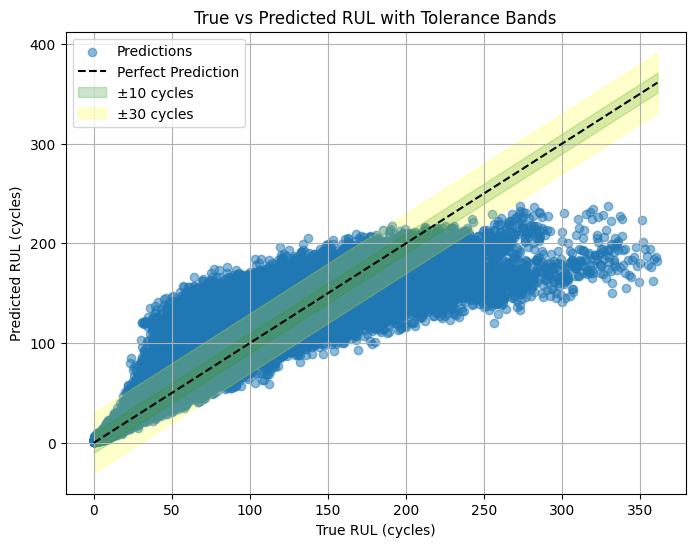

In [11]:
import matplotlib.pyplot as plt

# Scatter plot: True RUL vs Predicted RUL
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, alpha=0.5, label="Predictions")

# Tolerance bands
x_vals = np.linspace(min(y_true), max(y_true), 100)
plt.plot(x_vals, x_vals, 'k--', label="Perfect Prediction")
plt.fill_between(x_vals, x_vals-10, x_vals+10, color='green', alpha=0.2, label="±10 cycles")
plt.fill_between(x_vals, x_vals-30, x_vals+30, color='yellow', alpha=0.2, label="±30 cycles")

plt.xlabel("True RUL (cycles)")
plt.ylabel("Predicted RUL (cycles)")
plt.title("True vs Predicted RUL with Tolerance Bands")
plt.legend()
plt.grid(True)
plt.show()


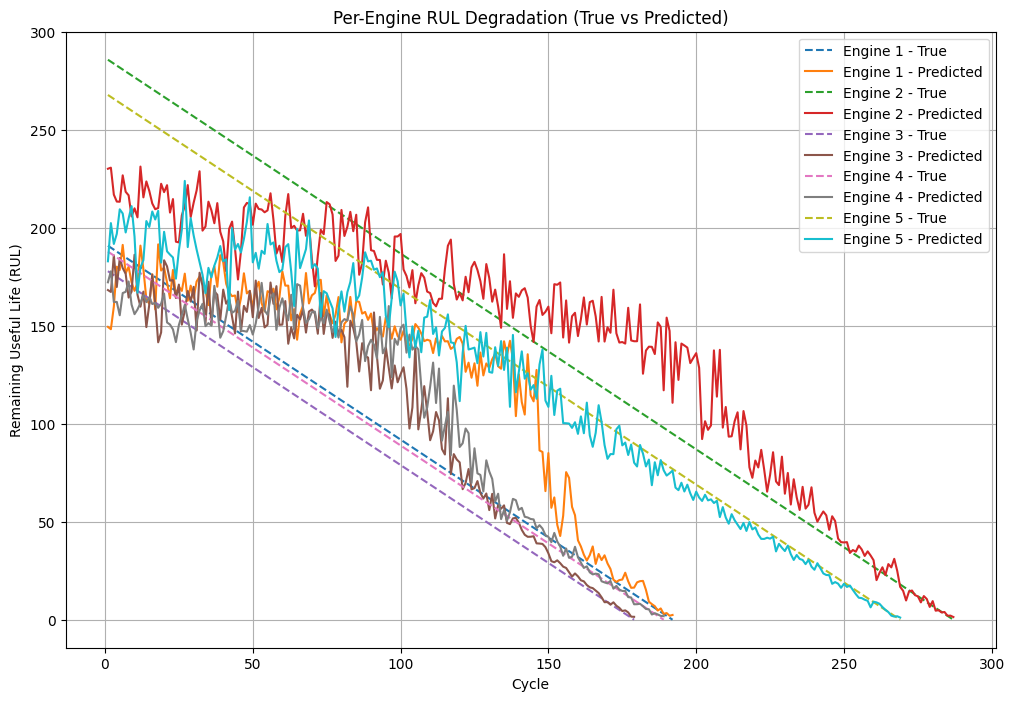

In [12]:
# Pick a few engines to visualize (to keep it readable)
sample_engines = df_results['engine_id'].unique()[:5]  # first 5 engines

plt.figure(figsize=(12, 8))

for eng in sample_engines:
    eng_data = df_results[df_results['engine_id'] == eng]
    plt.plot(eng_data['cycle'], eng_data['RUL'], label=f"Engine {eng} - True", linestyle='--')
    plt.plot(eng_data['cycle'], eng_data['Predicted_RUL'], label=f"Engine {eng} - Predicted")

plt.xlabel("Cycle")
plt.ylabel("Remaining Useful Life (RUL)")
plt.title("Per-Engine RUL Degradation (True vs Predicted)")
plt.legend()
plt.grid(True)
plt.show()


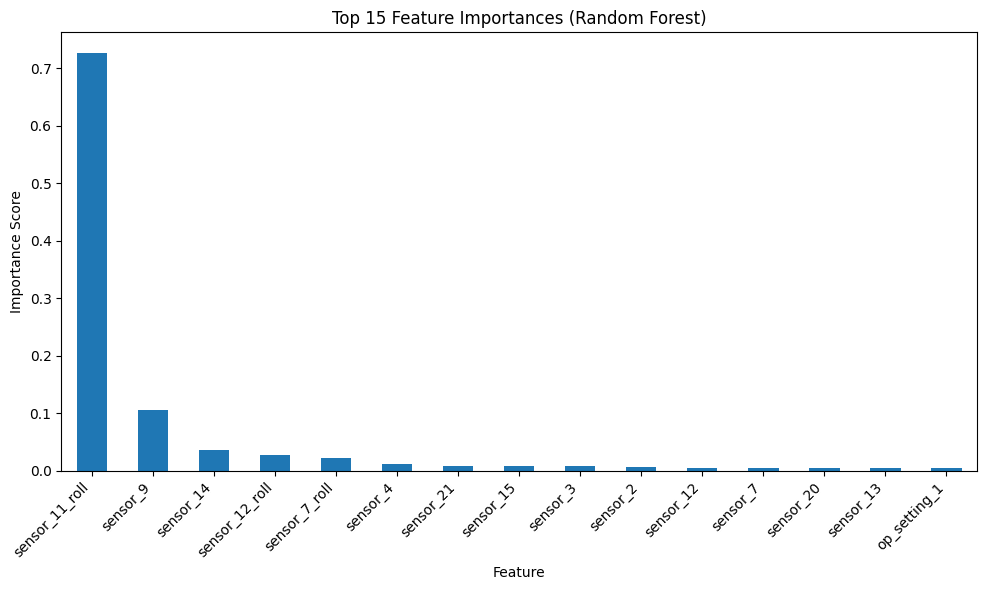

In [13]:
import pandas as pd

# Get feature importance values from the Random Forest
importances = model.feature_importances_
feature_names = X.columns

# Sort by importance
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
feat_imp.head(15).plot(kind='bar')
plt.title("Top 15 Feature Importances (Random Forest)")
plt.ylabel("Importance Score")
plt.xlabel("Feature")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [14]:
# Export predictions to CSV
output_file = "predictions_rf.csv"
df_results[['engine_id', 'cycle', 'RUL', 'Predicted_RUL']].to_csv(output_file, index=False)

print(f"✅ Predictions saved to {output_file}")


✅ Predictions saved to predictions_rf.csv


In [15]:
from src.model_utils import train_random_forest, save_model

# 1. Prepare features/labels
X = df_feat.drop(columns=['engine_id', 'cycle', 'RUL'])
y = df_feat['RUL']
groups = df_feat['engine_id']

# 2. Train model
model = train_random_forest(X, y, groups, n_estimators=100, max_depth=10)

# 3. Save model WITH feature names
save_model(model, "rf_model_test.pkl", feature_names=X.columns.tolist())


Fold 1: MAE=31.55, RMSE=45.73
Fold 2: MAE=30.21, RMSE=42.91
Fold 3: MAE=26.95, RMSE=39.39
Fold 4: MAE=32.95, RMSE=44.73
Fold 5: MAE=26.31, RMSE=37.62

Avg MAE=29.60, Avg RMSE=42.08


TypeError: save_model() got an unexpected keyword argument 'feature_names'

In [1]:
from src.data_loader import load_fd001
from src.features import add_features, add_rul
from src.model_utils import train_random_forest, save_model

# 1. Load dataset (now with consistent column names!)
df = load_fd001("data/train_FD001.txt")

# 2. Add RUL + engineered features
df_rul = add_rul(df)
df_feat = add_features(df_rul)

# 3. Train model
X = df_feat.drop(columns=['engine_id', 'cycle', 'RUL'])
y = df_feat['RUL']
groups = df_feat['engine_id']

model = train_random_forest(X, y, groups, n_estimators=100, max_depth=10)

# 4. Save model WITH feature names baked in
save_model(model, "rf_model_test.pkl", feature_names=X.columns.tolist())


✅ Model saved to rf_model_test.pkl


In [2]:
X = df_feat.drop(columns=['engine_id', 'RUL'])
y = df_feat['RUL']
groups = df_feat['engine_id']

model = train_random_forest(X, y, groups, n_estimators=100, max_depth=10)
save_model(model, "rf_model_test.pkl", feature_names=X.columns.tolist())


✅ Model saved to rf_model_test.pkl
